# Features selection for the 12 months prediction

## Libraries

In [66]:
## for data
import pandas as pd
import numpy as np # Used to do data processing

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy.stats as stats
import statsmodels.formula.api as smf
# import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # Used to check stationarity 

## for machine learning
import sklearn
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

## for cleaning data
from DreamLib.processing_datas import *

In [67]:
sns.set(rc={"figure.figsize":(18, 6)})

color: https://matplotlib.org/stable/gallery/color/named_colors.html

# Data importation and formating

In [68]:
# Same link for everyone:
data = pd.read_sas("datas/construct_red.sas7bdat")

In [69]:
dft, Yt = clean_data(data,start=1,period=12,chronique=b'Totale',col_used=None,split=0,norm="Not")
df2, Y2 = clean_data(data,start=1,period=12,chronique=b'CHR2',col_used=None,split=0,norm="Not")
df8, Y8 = clean_data(data,start=1,period=12,chronique=b'CHR8',col_used=None,split=0,norm="Not")

# Split Data set

On sépare les catégories de données

In [70]:
col_portefeuille = ['mean_1', 'median_1', 'p5_1', 'p10_1', 'p25_1', 'p75_1', 'p90_1',
       'p95_1', 'mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2',
       'p90_2', 'p95_2', 'mean_3', 'median_3', 'p5_3', 'p10_3', 'p25_3',
       'p75_3', 'p90_3', 'p95_3', 'mean_4', 'median_4', 'p5_4', 'p10_4',
       'p25_4', 'p75_4', 'p90_4', 'p95_4', 'mean_5', 'p5_5',
       'p10_5', 'p25_5', 'p75_5', 'p90_5', 'p95_5', 'mean_6', 'median_6',
       'p5_6', 'p10_6', 'p25_6', 'p75_6', 'p90_6', 'p95_6', 'mean_7',
       'median_7', 'p5_7', 'p10_7', 'p25_7', 'p75_7', 'p90_7', 'p95_7',
       'mean_8', 'median_8', 'p5_8', 'p10_8', 'p25_8', 'p75_8', 'p90_8',
       'p95_8']
       
col_clients = ['CD_TY_CLI_RCI_1','CD_ETA_CIV_1','CD_MOD_HABI_1', 'CD_PROF_1',
       'CD_PROF_2', 'CD_QUAL_VEH_1']

col_macro = ['PIB',
       'Inflation', 'Tx_cho']

Definition des 3 datasets des 3 chroniques

In [71]:
Xt = dft[[*col_portefeuille,*col_clients,*col_macro]]
X2 = df2[[*col_portefeuille,*col_clients,*col_macro]]
X8 = df8[[*col_portefeuille,*col_clients,*col_macro]]

# Feature selection explication methodes

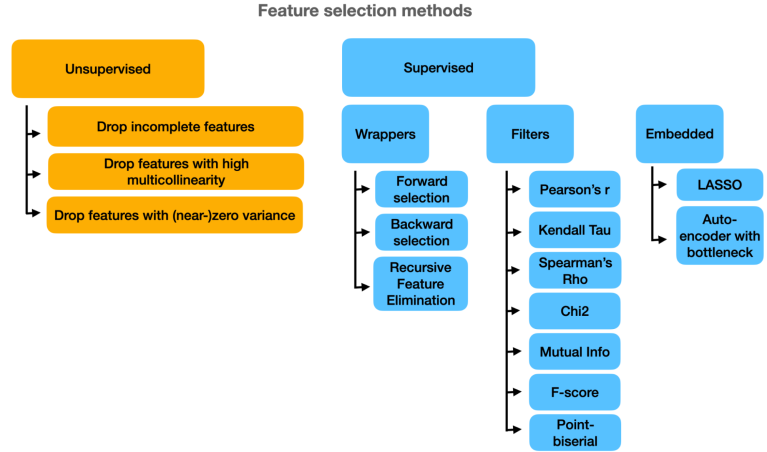




*   https://neptune.ai/blog/feature-selection-methods
*   https://en.wikipedia.org/wiki/Feature_selection#Main_principles
* https://scikit-learn.org/stable/modules/feature_selection.html



* **Approche graphique**: approche naive

*   **Unsupervised methods**: Low variance
*   **Wrapper methods**:
  * **Backward selection**: SequentialFeatureSelector Backward
  * **Forward selection**: SequentialFeatureSelector Forward
  * **Recursive Feature Elimination**: Recursive Feature Elimination,Tree-based feature selection, SelectFromModel
* **Filter method**: correlation analysis, Kbest



# Feature selection de chronique totale

## Analyse des correlations

In [72]:
def corre(X,Y):
  X.insert(0, 'DR', Y)
  cor = X.corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
  plt.show()

### Analyse des variables caractéristiques du portfeuille

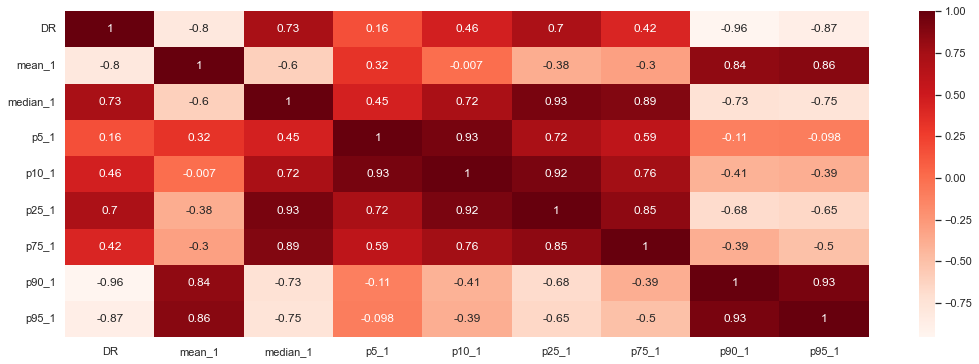

In [73]:
# Note d'octroi recalulée
corre(Xt[col_portefeuille[0:8]],Yt)

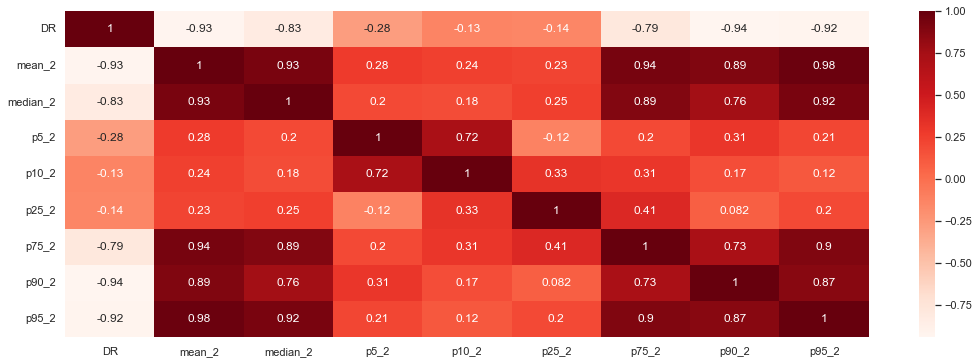

In [74]:
#Durée écoulée depuis le dernier impayé
corre(Xt[col_portefeuille[8:16]],Yt)

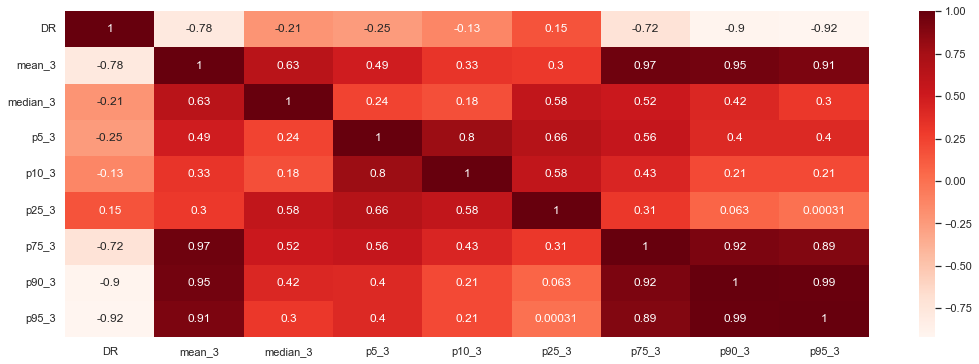

In [75]:
# Durée de l'impayé encours
corre(Xt[col_portefeuille[16:24]],Yt)

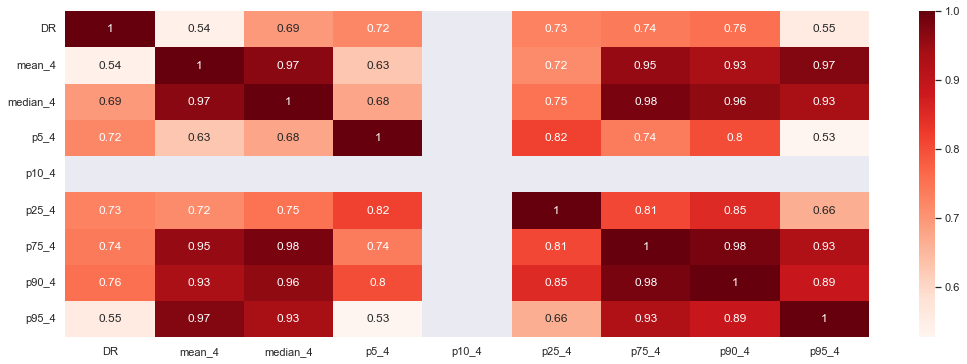

In [76]:
# Durée maximale de l'impayé
corre(Xt[col_portefeuille[24:32]],Yt)

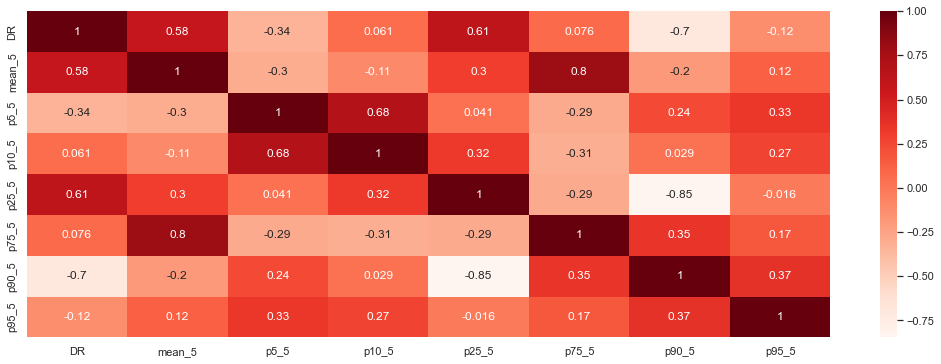

In [77]:
# Créance après répartition solde créditeurs
corre(Xt[col_portefeuille[32:39]],Yt)

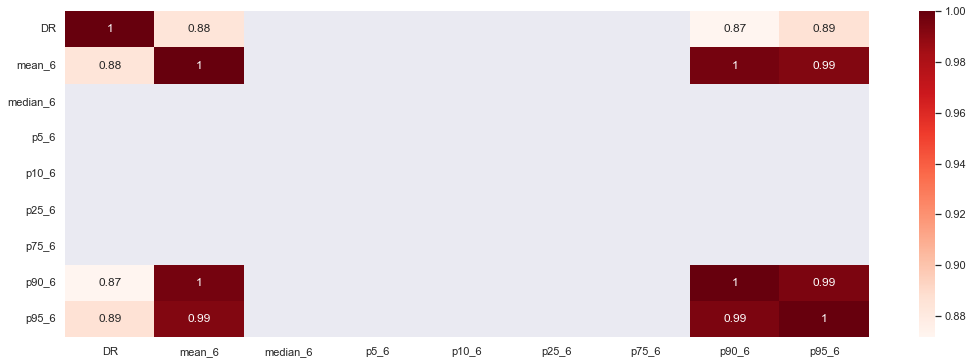

In [78]:
# Ratio nombre d'incidents régularisés enregistrés depuis la date d'entrée en gestion
corre(Xt[col_portefeuille[39:47]],Yt)

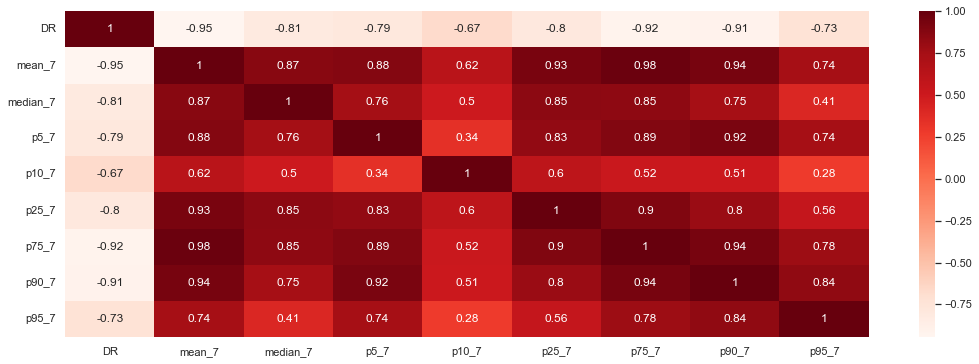

In [79]:
# Ratio rang du premier impayé régularisé par rapport à la durée prévue du contrat
corre(Xt[col_portefeuille[47:55]],Yt)

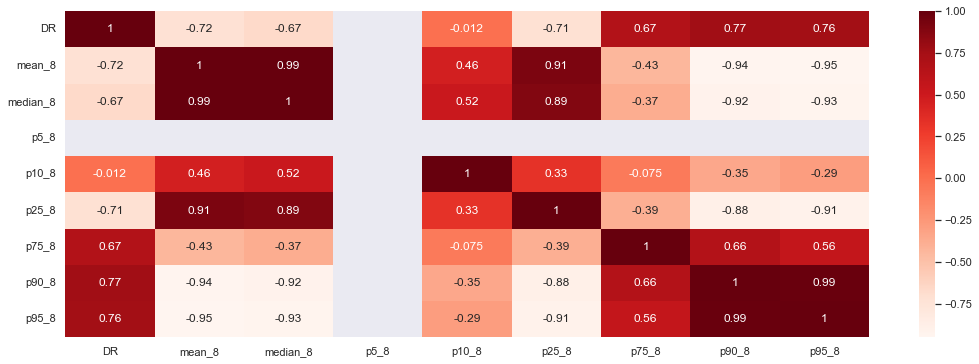

In [80]:
# Pourcentage apport
corre(Xt[col_portefeuille[55:63]],Yt)

### Analyse des variables caractéristiques des clients

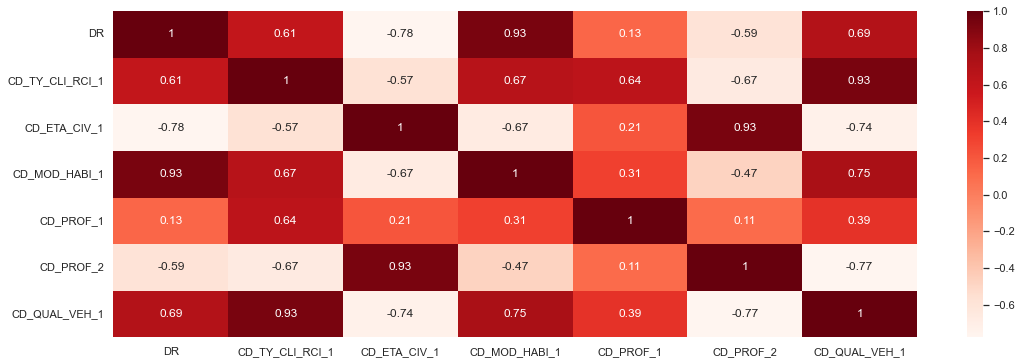

In [81]:
corre(Xt[col_clients],Yt)

### Analyse des variables macro

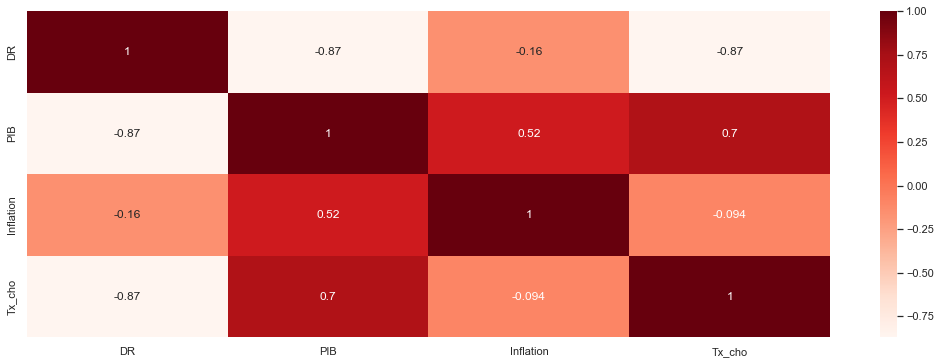

In [82]:
corre(Xt[col_macro],Yt)

### Multicollinéarité test
On va analyser les différentes colonnes obtenues et enlever les variables qui sont trop colinéaires entre elles

In [83]:
def keep_col(df,Y,tresholdDR,interTreshold):
  df_temp = df.copy()
  df_temp.insert(loc=0, column='DR', value=Y.values)
  corr_matrix = df_temp.corr()
  *index, = map(lambda x: abs(x)>tresholdDR,corr_matrix.loc['DR'])
  print('Columns with corr with DR >' +str(tresholdDR)+':',df_temp.columns[index].values[1:],str(index.count(True)-1)+' variables',sep='\n')
  
  print('\n','After studying inter correlation')
  keep_col = set()
  cols = df_temp.columns[index].values[1:]
  for col1 in cols:
    for col2 in cols:
      if col1 != col2 and abs(corr_matrix.loc[col1,col2])>interTreshold:
        col_to_keep =corr_matrix.loc['DR',[col1,col2]].idxmax()
        keep_col.add(col_to_keep)
  print('Columns with inter corr<' +str(interTreshold)+':',keep_col,str(len(keep_col))+' variables',sep='\n')
  return list(keep_col)

In [84]:
col_totale_corr = keep_col(Xt,Yt,0.80,0.90)

Columns with corr with DR >0.8:
['mean_1' 'p90_1' 'p95_1' 'mean_2' 'median_2' 'p90_2' 'p95_2' 'p90_3'
 'p95_3' 'mean_6' 'p90_6' 'p95_6' 'mean_7' 'median_7' 'p75_7' 'p90_7'
 'CD_MOD_HABI_1' 'PIB' 'Tx_cho']
19 variables

 After studying inter correlation
Columns with inter corr<0.9:
{'p95_3', 'mean_7', 'p95_6', 'median_2', 'CD_MOD_HABI_1', 'PIB', 'p90_6', 'p95_2', 'p90_2', 'p90_3', 'p75_7', 'p90_7', 'mean_1', 'mean_6', 'p95_1', 'Tx_cho', 'mean_2'}
17 variables


### Conclusion

In [85]:
print(f'Il y a {len(col_totale_corr)} variables:', col_totale_corr,sep='\n')

Il y a 17 variables:
['p95_3', 'mean_7', 'p95_6', 'median_2', 'CD_MOD_HABI_1', 'PIB', 'p90_6', 'p95_2', 'p90_2', 'p90_3', 'p75_7', 'p90_7', 'mean_1', 'mean_6', 'p95_1', 'Tx_cho', 'mean_2']


On garde cette sélection de variables que l'on va ajouter dans notre fichier columns.py

## Low variance method

In [86]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold =0.25).fit(Xt)
col_totale_vt = Xt.loc[:,vt.get_support()].columns
print(f'Il y a {len(col_totale_vt)} variables:', col_totale_vt,sep='\n')

Il y a 30 variables:
Index(['mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2', 'p90_2',
       'p95_2', 'mean_3', 'median_3', 'p5_3', 'p10_3', 'p25_3', 'p75_3',
       'p90_3', 'p95_3', 'mean_4', 'median_4', 'p75_4', 'p90_4', 'p95_4',
       'mean_5', 'p5_5', 'p10_5', 'p25_5', 'p75_5', 'p90_5', 'p95_5', 'PIB',
       'Inflation'],
      dtype='object')


## Kbest method

In [87]:
from sklearn.feature_selection import SelectKBest, f_regression
kb = SelectKBest(f_regression, k=20).fit(Xt, Yt)
col_totale_kb = Xt.loc[:,kb.get_support()].columns
print(f'Il y a {len(col_totale_kb)} variables:', col_totale_kb,sep='\n')

Il y a 20 variables:
Index(['mean_1', 'p90_1', 'p95_1', 'mean_2', 'median_2', 'p90_2', 'p95_2',
       'p90_3', 'p95_3', 'mean_6', 'p90_6', 'p95_6', 'mean_7', 'median_7',
       'p25_7', 'p75_7', 'p90_7', 'CD_MOD_HABI_1', 'PIB', 'Tx_cho'],
      dtype='object')


## Recursive feature elimination with cross-validation to select features.



In [88]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
rfecv = RFECV(linreg, step=1, min_features_to_select=15, cv=8).fit(Xt, Yt)
col_totale_rfecv = Xt.loc[:,rfecv.get_support()].columns
print(f'Il y a {len(col_totale_rfecv)} variables:', col_totale_rfecv,sep='\n')

Il y a 29 variables:
Index(['mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2', 'p90_2',
       'p95_2', 'mean_3', 'median_3', 'p5_3', 'p10_3', 'p25_3', 'p75_3',
       'p90_3', 'p95_3', 'mean_4', 'median_4', 'p5_4', 'p25_4', 'p75_4',
       'p90_4', 'p95_4', 'p10_7', 'p25_7', 'p90_7', 'median_8', 'p25_8',
       'Tx_cho'],
      dtype='object')


## Feature selection using SelectFromModel

In [89]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(fit_intercept=False)
sfm = SelectFromModel(linreg).fit(Xt, Yt)
col_totale_sfm  = Xt.loc[:,sfm .get_support()].columns
print(f'Il y a {len(col_totale_sfm )} variables:', col_totale_sfm ,sep='\n')

Il y a 19 variables:
Index(['mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2', 'p90_2',
       'p95_2', 'median_3', 'p5_3', 'p25_3', 'p90_3', 'p95_3', 'mean_4',
       'median_4', 'p25_4', 'p75_4', 'p90_4', 'p95_4'],
      dtype='object')


## Tree-based feature selection

In [90]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
etc = ExtraTreesRegressor(n_estimators=50).fit(Xt, Yt)
sfm2 = SelectFromModel(etc, prefit=True)
col_totale_sfm2  = Xt.loc[:,sfm2 .get_support()].columns
print(f'Il y a {len(col_totale_sfm2 )} variables:', col_totale_sfm2 ,sep='\n')

Il y a 25 variables:
Index(['mean_1', 'p25_1', 'p90_1', 'mean_2', 'p90_2', 'p75_4', 'p90_4',
       'p75_5', 'p90_5', 'mean_6', 'p90_6', 'p95_6', 'mean_7', 'median_7',
       'p5_7', 'p75_7', 'p90_7', 'p25_8', 'p90_8', 'p95_8', 'CD_TY_CLI_RCI_1',
       'CD_MOD_HABI_1', 'CD_QUAL_VEH_1', 'PIB', 'Tx_cho'],
      dtype='object')


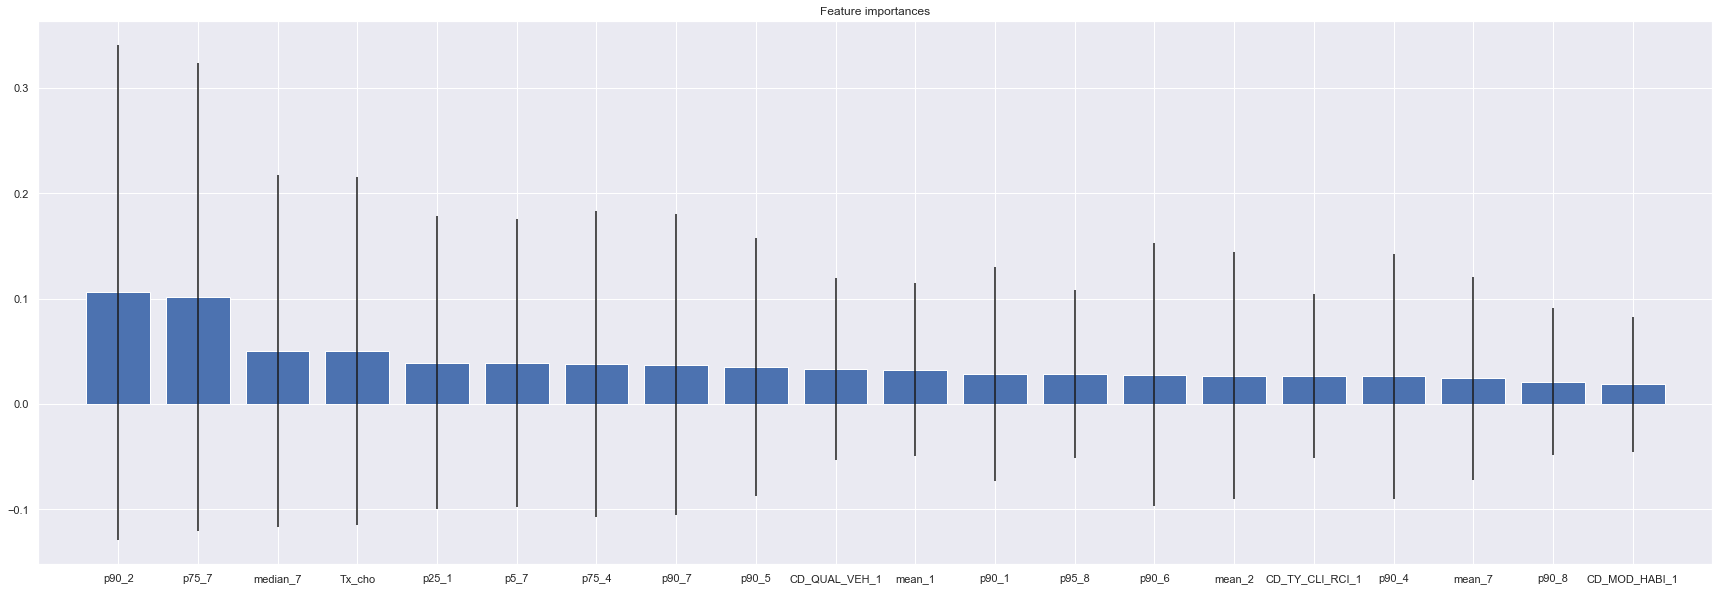

In [91]:
#plot the importances #
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:20]
indices_names = list(map(lambda x : Xt.columns[x],indices))
plt.figure(figsize=(30,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), indices_names)
plt.xlim([-1, len(indices)])
plt.show()

## Sequential Feature Selection 

In [92]:
# forward
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
linreg = LinearRegression(fit_intercept=False)
sfs_forward = SequentialFeatureSelector(linreg, n_features_to_select=20, direction='forward').fit(Xt, Yt)
col_totale_sfs_forward  = Xt.loc[:,sfs_forward .get_support()].columns
print(f'Il y a {len(col_totale_sfs_forward )} variables:', col_totale_sfs_forward ,sep='\n')

Il y a 20 variables:
Index(['p5_2', 'p10_2', 'p25_2', 'p75_2', 'p95_2', 'p5_3', 'p10_3', 'p5_5',
       'p95_5', 'median_6', 'p5_6', 'p10_6', 'p25_6', 'p75_6', 'p10_7',
       'p25_7', 'p5_8', 'p75_8', 'CD_MOD_HABI_1', 'PIB'],
      dtype='object')


In [93]:
# backward
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
linreg = LinearRegression(fit_intercept=False)
sfs_backward = SequentialFeatureSelector(linreg, n_features_to_select=20, direction='backward').fit(Xt, Yt)
col_totale_sfs_backward  = Xt.loc[:,sfs_backward .get_support()].columns
print(f'Il y a {len(col_totale_sfs_backward )} variables:', col_totale_sfs_backward ,sep='\n')

Il y a 20 variables:
Index(['median_2', 'p5_2', 'p25_2', 'p90_2', 'p10_3', 'p25_3', 'p75_3',
       'p90_3', 'p95_3', 'median_4', 'p90_4', 'p95_4', 'mean_5', 'p5_5',
       'p10_5', 'p25_5', 'p75_5', 'p90_5', 'p95_5', 'PIB'],
      dtype='object')


## Show what feature was selected

In [94]:
cols_feature_selection = [col_totale_corr,col_totale_vt,col_totale_kb,col_totale_rfecv,col_totale_sfm,col_totale_sfm2,col_totale_sfs_forward,col_totale_sfs_backward]
method = ['Methode correlation','Low variance methode','Methode Kbest','Methode RFECV','Methode SelectFromModel','Method Tree','Methode sequential forward','Methode sequential backward']

In [150]:
for cols, met in zip(cols_feature_selection,method):
  print('-'*40)
  print(f'{met}: {len(cols)} variables')
  print(*cols)
print('-'*40,end='\n')

----------------------------------------
Methode correlation: 17 variables
p95_3 mean_7 p95_6 median_2 CD_MOD_HABI_1 PIB p90_6 p95_2 p90_2 p90_3 p75_7 p90_7 mean_1 mean_6 p95_1 Tx_cho mean_2
----------------------------------------
Low variance methode: 30 variables
mean_2 median_2 p5_2 p10_2 p25_2 p75_2 p90_2 p95_2 mean_3 median_3 p5_3 p10_3 p25_3 p75_3 p90_3 p95_3 mean_4 median_4 p75_4 p90_4 p95_4 mean_5 p5_5 p10_5 p25_5 p75_5 p90_5 p95_5 PIB Inflation
----------------------------------------
Methode Kbest: 20 variables
mean_1 p90_1 p95_1 mean_2 median_2 p90_2 p95_2 p90_3 p95_3 mean_6 p90_6 p95_6 mean_7 median_7 p25_7 p75_7 p90_7 CD_MOD_HABI_1 PIB Tx_cho
----------------------------------------
Methode RFECV: 29 variables
mean_2 median_2 p5_2 p10_2 p25_2 p75_2 p90_2 p95_2 mean_3 median_3 p5_3 p10_3 p25_3 p75_3 p90_3 p95_3 mean_4 median_4 p5_4 p25_4 p75_4 p90_4 p95_4 p10_7 p25_7 p90_7 median_8 p25_8 Tx_cho
----------------------------------------
Methode SelectFromModel: 19 variables


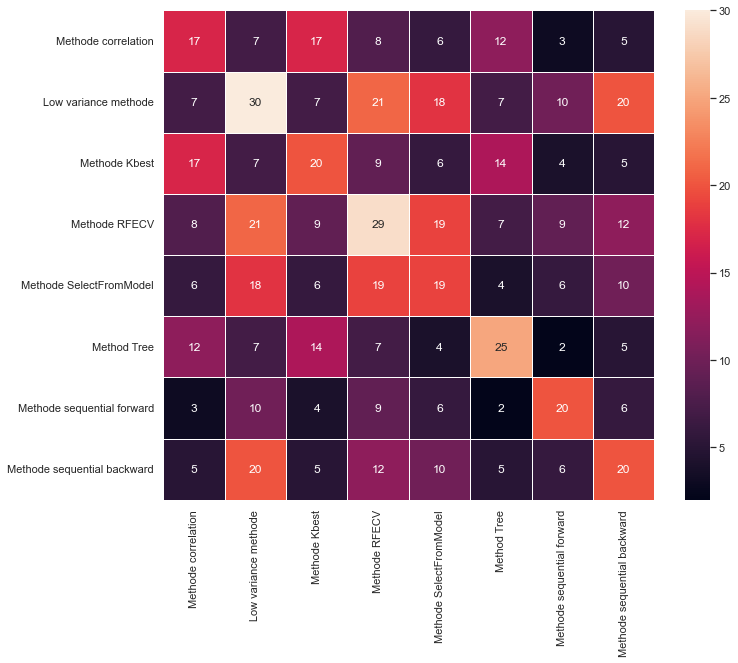

In [96]:
import itertools
df_common = pd.DataFrame(columns=method, index=method)
for i, j in itertools.product(range(len(method)),range(len(method))):
  col1, col2 = cols_feature_selection[i], cols_feature_selection[j]
  method1, method2 = method[i], method[j]
  n_common = len(set(col1).intersection(col2))
  df_common.loc[method1,method2] = n_common

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_common.astype('float64'), annot=True,linewidth=.5,ax=ax)
plt.show()

# Feature selection de chronique 2

## Analyse des correlations

In [97]:
def corre(X,Y):
  X.insert(0, 'DR', Y)
  cor = X.corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
  plt.show()

### Analyse des variables caractéristiques du portfeuille

In [98]:
col_2_corr = []

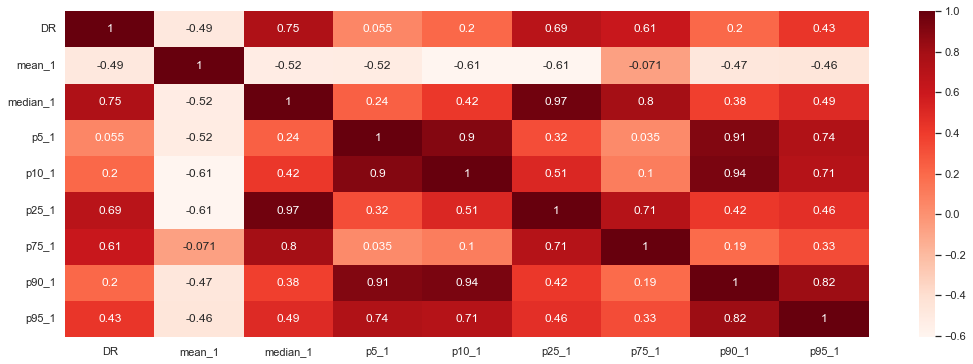

In [99]:
# Note d'octroi recalulée
corre(X2[col_portefeuille[0:8]],Y2)

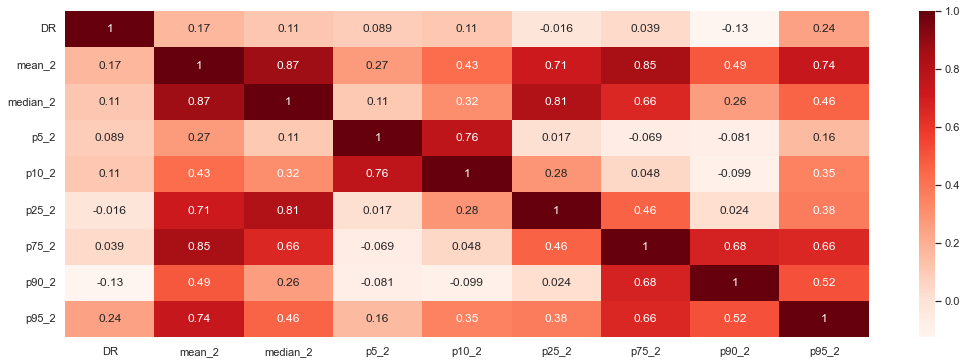

In [100]:
#Durée écoulée depuis le dernier impayé
corre(X2[col_portefeuille[8:16]],Y2)

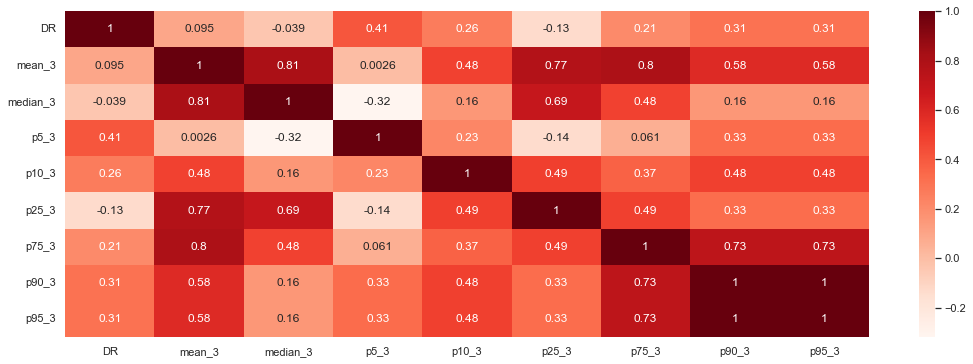

In [101]:
# Durée de l'impayé encours
corre(X2[col_portefeuille[16:24]],Y2)

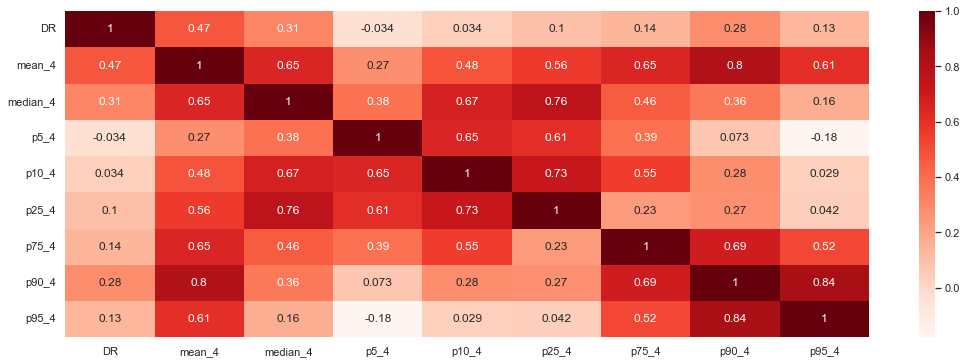

In [102]:
# Durée maximale de l'impayé
corre(X2[col_portefeuille[24:32]],Y2)

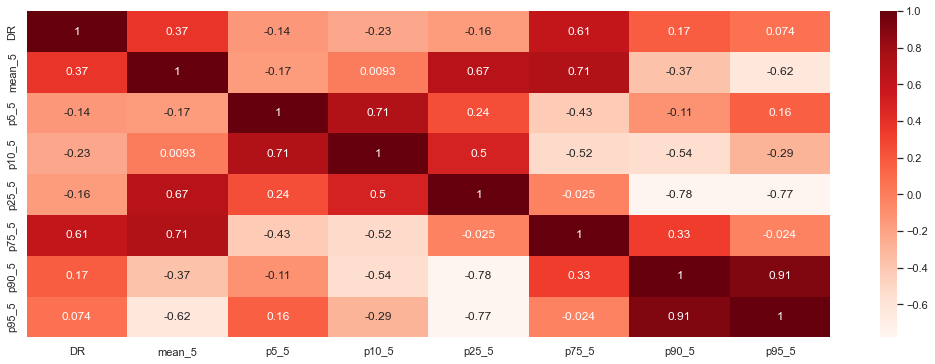

In [103]:
# Créance après répartition solde créditeurs
corre(X2[col_portefeuille[32:39]],Y2)

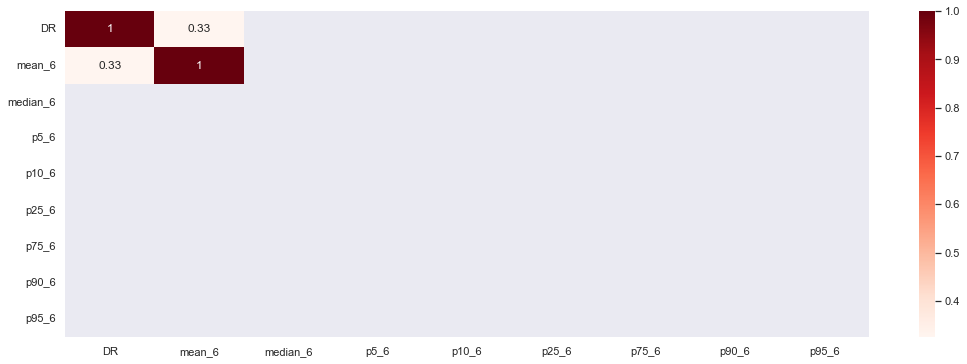

In [104]:
# Ratio nombre d'incidents régularisés enregistrés depuis la date d'entrée en gestion
corre(X2[col_portefeuille[39:47]],Y2)

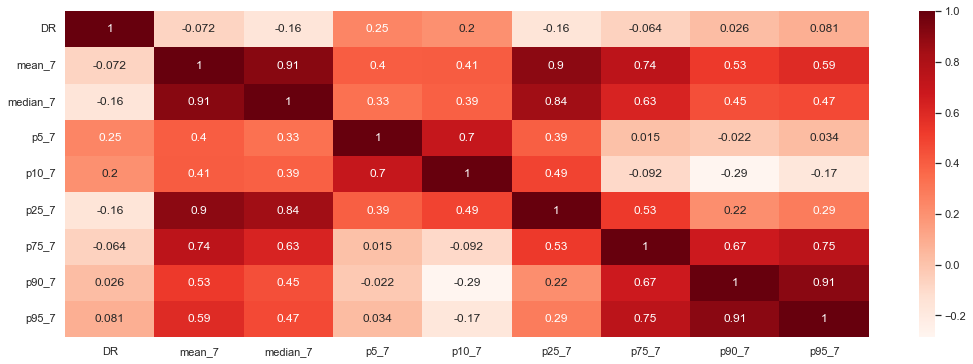

In [105]:
# Ratio rang du premier impayé régularisé par rapport à la durée prévue du contrat
corre(X2[col_portefeuille[47:55]],Y2)

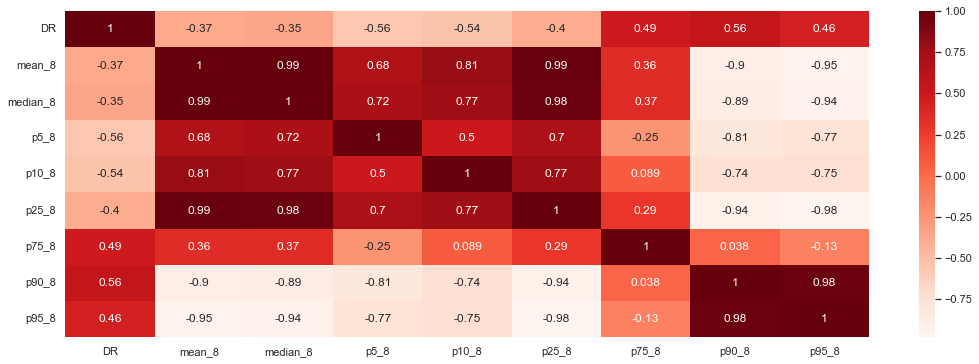

In [106]:
# Pourcentage apport
corre(X2[col_portefeuille[55:63]],Y2)

### Analyse des variables caractéristiques des clients

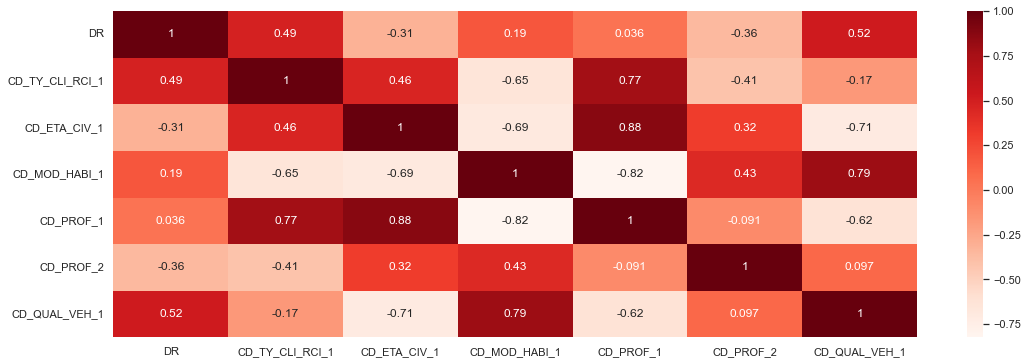

In [107]:
corre(X2[col_clients],Y2)

### Analyse des variables macro

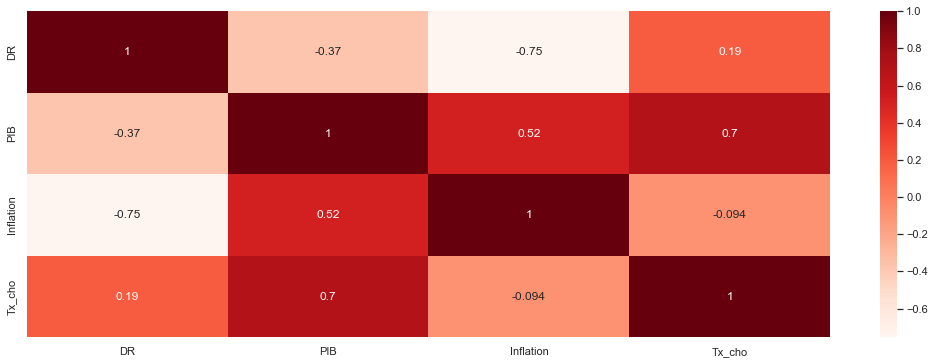

In [108]:
corre(X2[col_macro],Y2)

### Multicollinéarité test
On va analyser les différentes colonnes obtenues et enlever les variables qui sont trop colinéaires entre elles

In [109]:
def keep_col(df, Y, tresholdDR,interTreshold):
  df_temp = df.copy()
  df_temp.insert(loc=0, column='DR', value=Y2.values)
  corr_matrix = df_temp.corr()
  *index, = map(lambda x: abs(x)>tresholdDR,corr_matrix.loc['DR'])
  print('Columns with corr with DR >' +str(tresholdDR)+':',df_temp.columns[index].values[1:],str(index.count(True)-1)+' variables',sep='\n')
  
  print('\n','After studying inter correlation')
  keep_col = set()
  cols = df_temp.columns[index].values[1:]
  for col1 in cols:
    for col2 in cols:
      if col1 != col2 and abs(corr_matrix.loc[col1,col2])>interTreshold:
        col_to_keep =corr_matrix.loc['DR',[col1,col2]].idxmax()
        keep_col.add(col_to_keep)
  print('Columns with inter corr<' +str(interTreshold)+':',keep_col,str(len(keep_col))+' variables',sep='\n')
  return list(keep_col)

In [110]:
col_2_corr = keep_col(X2, Y2,0.60,0.90)

Columns with corr with DR >0.6:
['median_1' 'p25_1' 'p75_1' 'p75_5' 'Inflation']
5 variables

 After studying inter correlation
Columns with inter corr<0.9:
{'median_1'}
1 variables


### Conclusion

In [111]:
col_2_corr = list(set(col_2_corr))
print(f'Il y a {len(col_2_corr)} variables:', col_2_corr,sep='\n')

Il y a 1 variables:
['median_1']


## Low variance method

In [112]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold =0.25).fit(X2)
col_2_vt = X2.loc[:,vt.get_support()].columns
print(f'Il y a {len(col_2_vt)} variables:', col_2_vt,sep='\n')

Il y a 33 variables:
Index(['mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2', 'p90_2',
       'p95_2', 'mean_3', 'median_3', 'p5_3', 'p10_3', 'p25_3', 'p75_3',
       'p90_3', 'p95_3', 'mean_4', 'median_4', 'p5_4', 'p10_4', 'p25_4',
       'p75_4', 'p90_4', 'p95_4', 'mean_5', 'p5_5', 'p10_5', 'p25_5', 'p75_5',
       'p90_5', 'p95_5', 'PIB', 'Inflation'],
      dtype='object')


## Kbest method

In [113]:
from sklearn.feature_selection import SelectKBest, f_regression
kb = SelectKBest(f_regression, k=20).fit(X2, Y2)
col_2_kb = X2.loc[:,kb.get_support()].columns
print(f'Il y a {len(col_2_kb)} variables:', col_2_kb,sep='\n')

Il y a 20 variables:
Index(['mean_1', 'median_1', 'p25_1', 'p75_1', 'p95_1', 'p5_3', 'mean_4',
       'mean_5', 'p75_5', 'mean_8', 'p5_8', 'p10_8', 'p25_8', 'p75_8', 'p90_8',
       'p95_8', 'CD_TY_CLI_RCI_1', 'CD_QUAL_VEH_1', 'PIB', 'Inflation'],
      dtype='object')


## Recursive feature elimination



In [114]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
rfecv = RFECV(linreg, step=1,min_features_to_select=15, cv=8).fit(X2, Y2)
col_2_rfecv = X2.loc[:,rfecv.get_support()].columns
print(f'Il y a {len(col_2_rfecv)} variables:', col_2_rfecv,sep='\n')


Il y a 38 variables:
Index(['mean_2', 'median_2', 'p75_2', 'mean_3', 'median_3', 'p5_3', 'p10_3',
       'p25_3', 'p75_3', 'p90_3', 'p95_3', 'mean_4', 'median_4', 'p5_4',
       'p10_4', 'p25_4', 'p75_4', 'p90_4', 'p95_4', 'mean_7', 'median_7',
       'p5_7', 'p25_7', 'p75_7', 'p90_7', 'p95_7', 'mean_8', 'median_8',
       'p5_8', 'p10_8', 'p75_8', 'p90_8', 'p95_8', 'CD_ETA_CIV_1', 'CD_PROF_2',
       'CD_QUAL_VEH_1', 'Inflation', 'Tx_cho'],
      dtype='object')


## Feature selection using SelectFromModel

In [115]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(fit_intercept=False)
sfm = SelectFromModel(linreg).fit(X2, Y2)
col_2_sfm  = Xt.loc[:,sfm .get_support()].columns
print(f'Il y a {len(col_2_sfm )} variables:', col_2_sfm ,sep='\n')


Il y a 17 variables:
Index(['mean_2', 'median_2', 'p25_2', 'mean_3', 'median_3', 'p10_3', 'p25_3',
       'p75_3', 'p90_3', 'p95_3', 'mean_4', 'median_4', 'p5_4', 'p10_4',
       'p75_4', 'p90_4', 'Inflation'],
      dtype='object')


## Tree-based feature selection

In [116]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
etc = ExtraTreesRegressor(n_estimators=50).fit(X2, Y2)
sfm2 = SelectFromModel(etc, prefit=True)
col_2_sfm2  = X2.loc[:,sfm2 .get_support()].columns
print(f'Il y a {len(col_2_sfm2 )} variables:', col_2_sfm2 ,sep='\n')


Il y a 21 variables:
Index(['median_1', 'p5_1', 'p10_1', 'p25_1', 'p5_3', 'p5_4', 'p95_5',
       'median_7', 'p10_7', 'p90_7', 'median_8', 'p5_8', 'p25_8', 'p90_8',
       'p95_8', 'CD_TY_CLI_RCI_1', 'CD_PROF_1', 'CD_QUAL_VEH_1', 'PIB',
       'Inflation', 'Tx_cho'],
      dtype='object')


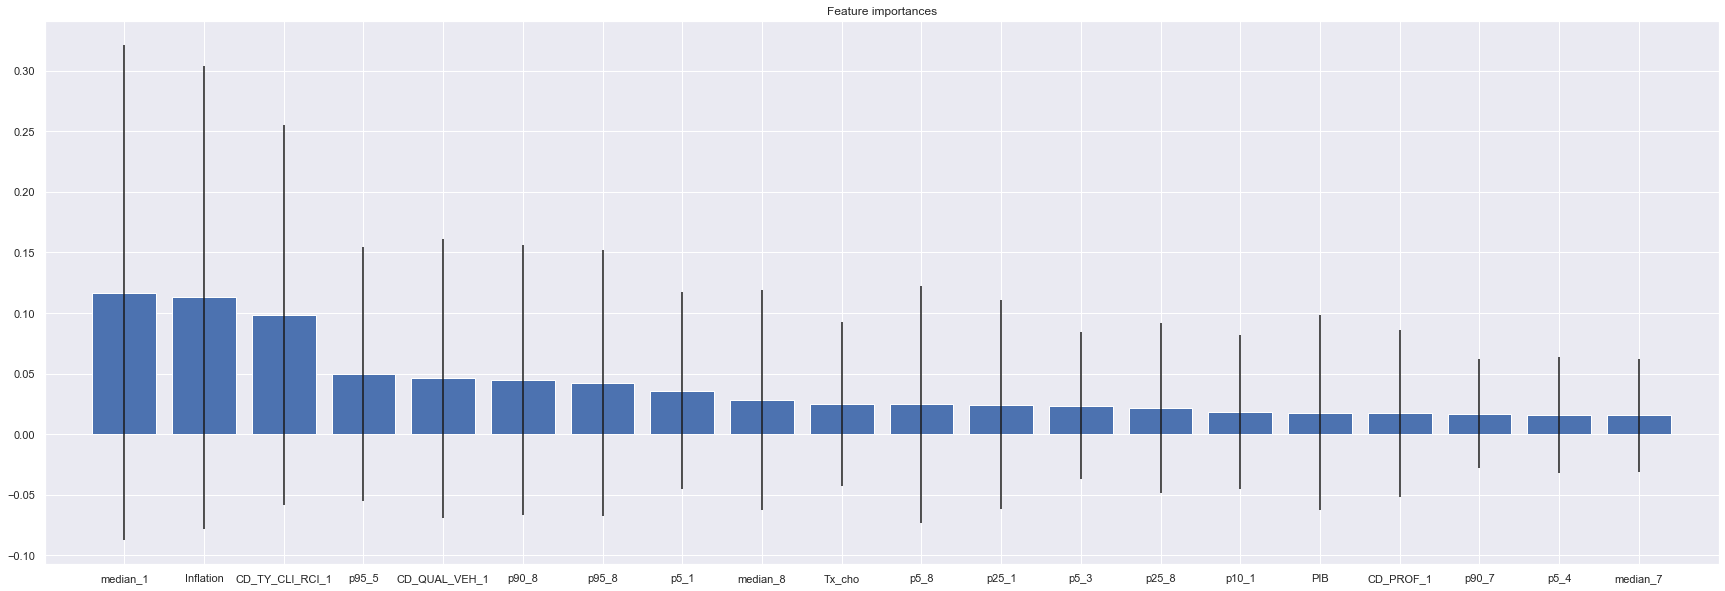

In [117]:
#plot the importances #
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:20]
indices_names = list(map(lambda x : X2.columns[x],indices))
plt.figure(figsize=(30,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), indices_names)
plt.xlim([-1, len(indices)])
plt.show()

## Sequential Feature Selection 

In [118]:
# forward
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
linreg = LinearRegression(fit_intercept=False)
sfs_forward = SequentialFeatureSelector(linreg, n_features_to_select=20, direction='forward').fit(X2, Y2)
col_2_sfs_forward  = X2.loc[:,sfs_forward .get_support()].columns
print(f'Il y a {len(col_2_sfs_forward )} variables:', col_2_sfs_forward ,sep='\n')

Il y a 20 variables:
Index(['p5_2', 'p10_2', 'p90_2', 'median_3', 'p25_3', 'p75_3', 'p5_4',
       'median_6', 'p5_6', 'p10_6', 'p25_6', 'p75_6', 'p90_6', 'p95_6',
       'p95_7', 'p5_8', 'p10_8', 'p90_8', 'CD_TY_CLI_RCI_1', 'CD_QUAL_VEH_1'],
      dtype='object')


In [119]:
# backward
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
linreg = LinearRegression(fit_intercept=False)
sfs_backward = SequentialFeatureSelector(linreg, n_features_to_select=20, direction='backward').fit(X2, Y2)
col_2_sfs_backward  = X2.loc[:,sfs_backward .get_support()].columns
print(f'Il y a {len(col_2_sfs_backward )} variables:', col_2_sfs_backward ,sep='\n')

Il y a 20 variables:
Index(['mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p95_2', 'mean_3',
       'p5_3', 'p25_3', 'p75_3', 'p95_3', 'p5_4', 'p90_4', 'p95_4', 'mean_5',
       'p10_5', 'p25_5', 'p75_5', 'p95_5', 'PIB'],
      dtype='object')


## Show what feature was selected

In [120]:
cols_feature_selection_2 = [col_2_corr,col_2_vt,col_2_kb,col_2_rfecv,col_2_sfm,col_2_sfm2,col_2_sfs_forward,col_2_sfs_backward]
method = ['Methode correlation','Low variance methode','Methode Kbest','Methode RFECV','Methode SelectFromModel','Method Tree','Methode sequential forward','Methode sequential backward']

In [121]:
for cols, met in zip(cols_feature_selection_2,method):
  print('-'*40)
  print(f'{met}: {len(cols)} variables')
  print(*cols)
print('-'*40,end='\n')

----------------------------------------
Methode correlation: 1 variables
median_1
----------------------------------------
Low variance methode: 33 variables
mean_2 median_2 p5_2 p10_2 p25_2 p75_2 p90_2 p95_2 mean_3 median_3 p5_3 p10_3 p25_3 p75_3 p90_3 p95_3 mean_4 median_4 p5_4 p10_4 p25_4 p75_4 p90_4 p95_4 mean_5 p5_5 p10_5 p25_5 p75_5 p90_5 p95_5 PIB Inflation
----------------------------------------
Methode Kbest: 20 variables
mean_1 median_1 p25_1 p75_1 p95_1 p5_3 mean_4 mean_5 p75_5 mean_8 p5_8 p10_8 p25_8 p75_8 p90_8 p95_8 CD_TY_CLI_RCI_1 CD_QUAL_VEH_1 PIB Inflation
----------------------------------------
Methode RFECV: 38 variables
mean_2 median_2 p75_2 mean_3 median_3 p5_3 p10_3 p25_3 p75_3 p90_3 p95_3 mean_4 median_4 p5_4 p10_4 p25_4 p75_4 p90_4 p95_4 mean_7 median_7 p5_7 p25_7 p75_7 p90_7 p95_7 mean_8 median_8 p5_8 p10_8 p75_8 p90_8 p95_8 CD_ETA_CIV_1 CD_PROF_2 CD_QUAL_VEH_1 Inflation Tx_cho
----------------------------------------
Methode SelectFromModel: 17 variables
me

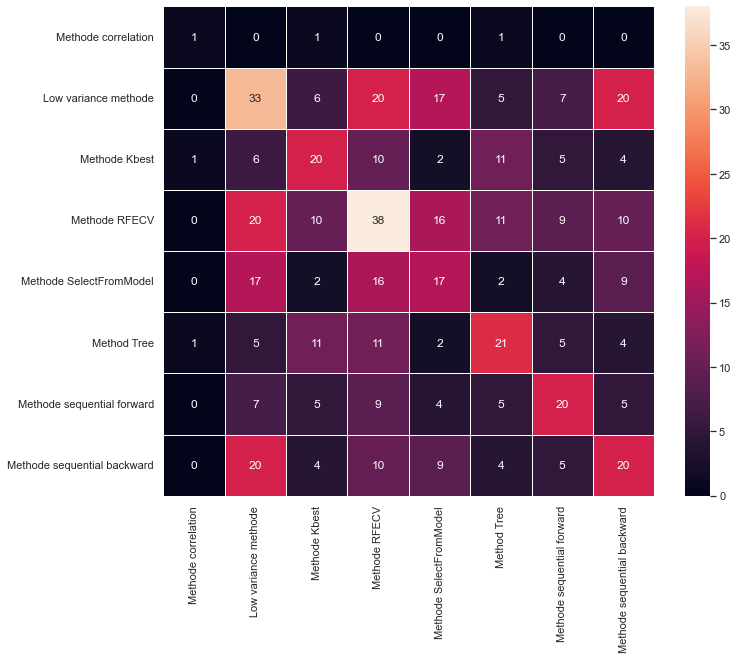

In [122]:
import itertools
df_common = pd.DataFrame(columns=method, index=method)
for i, j in itertools.product(range(len(method)),range(len(method))):
  col1, col2 = cols_feature_selection_2[i], cols_feature_selection_2[j]
  method1, method2 = method[i], method[j]
  n_common = len(set(col1).intersection(col2))
  df_common.loc[method1,method2] = n_common

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_common.astype('float64'), annot=True,linewidth=.5,ax=ax)
plt.show()

# Feature selection de chronique 8

## Analyse des correlations

In [123]:
def corre(X,Y):
  X.insert(0, 'DR', Y)
  cor = X.corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
  plt.show()

### Analyse des variables caractéristiques du portfeuille

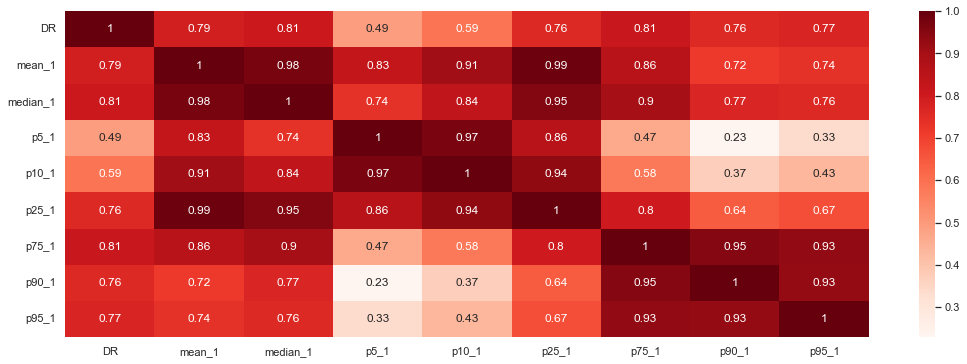

In [124]:
# Note d'octroi recalulée
corre(X8[col_portefeuille[0:8]],Y8)

In [125]:
#col_8_corr += ['mean_1','p90_1']

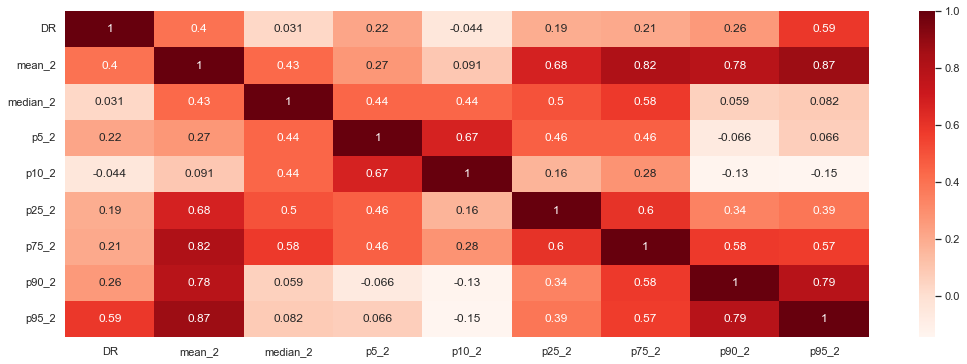

In [126]:
#Durée écoulée depuis le dernier impayé
corre(X8[col_portefeuille[8:16]],Y8)

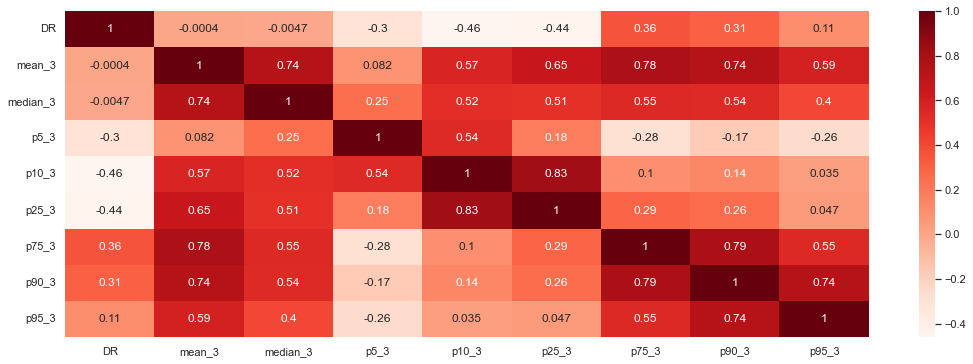

In [127]:
# Durée de l'impayé encours
corre(X8[col_portefeuille[16:24]],Y8)

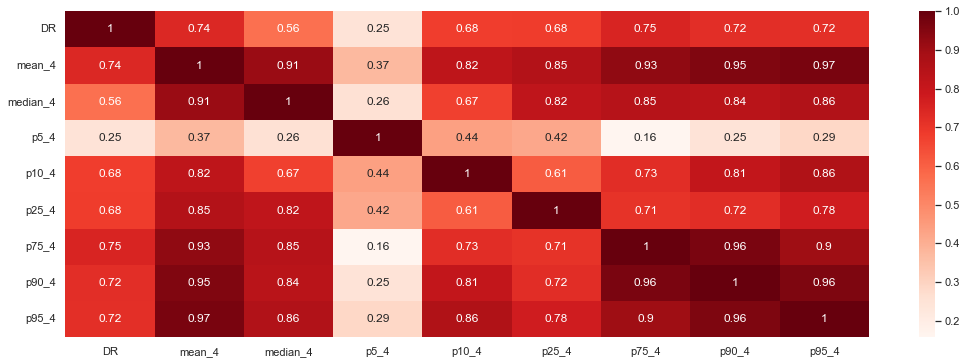

In [128]:
# Durée maximale de l'impayé
corre(X8[col_portefeuille[24:32]],Y8)

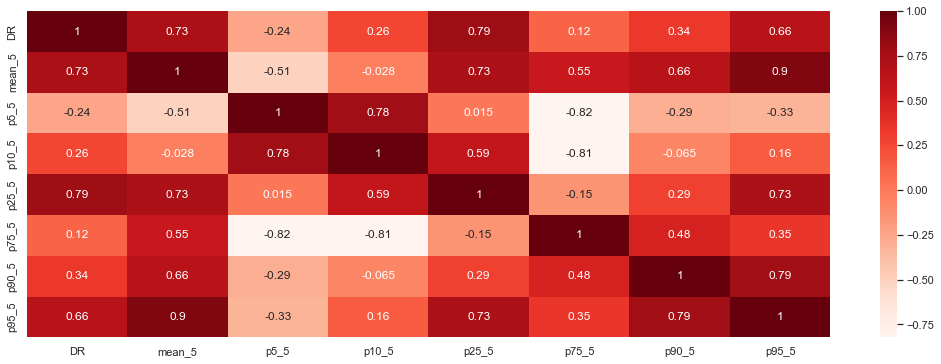

In [129]:
# Créance après répartition solde créditeurs
corre(X8[col_portefeuille[32:39]],Y8)

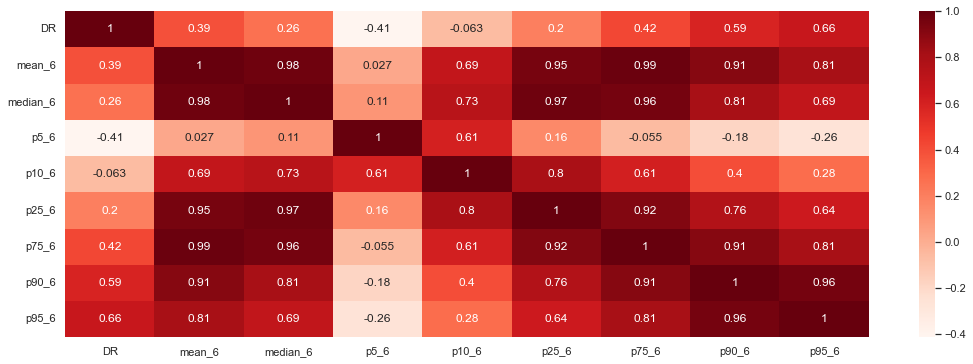

In [130]:
# Ratio nombre d'incidents régularisés enregistrés depuis la date d'entrée en gestion
corre(X8[col_portefeuille[39:47]],Y8)

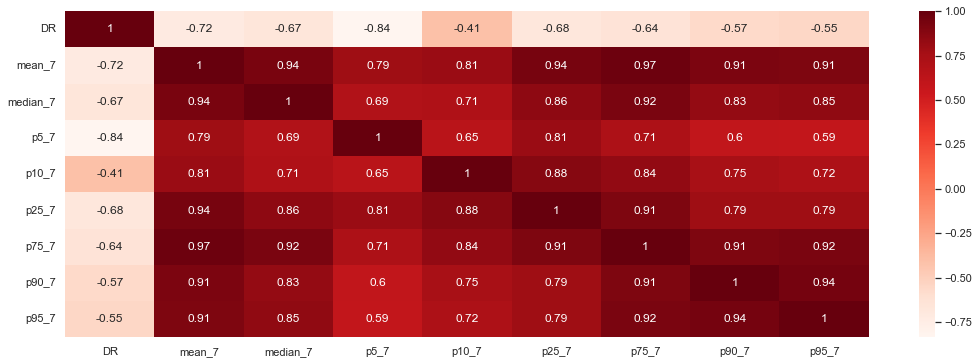

In [131]:
# Ratio rang du premier impayé régularisé par rapport à la durée prévue du contrat
corre(X8[col_portefeuille[47:55]],Y8)

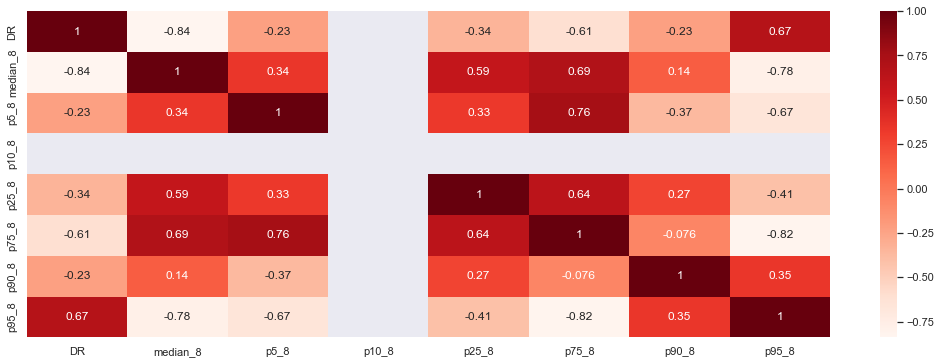

In [132]:
# Pourcentage apport
corre(X8[col_portefeuille[56:64]],Y8)

### Analyse des variables caractéristiques des clients

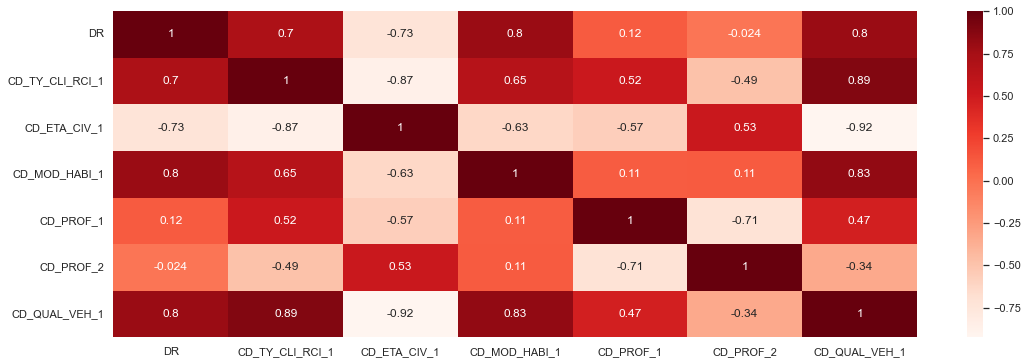

In [133]:
corre(X8[col_clients],Y8)

### Analyse des variables macro

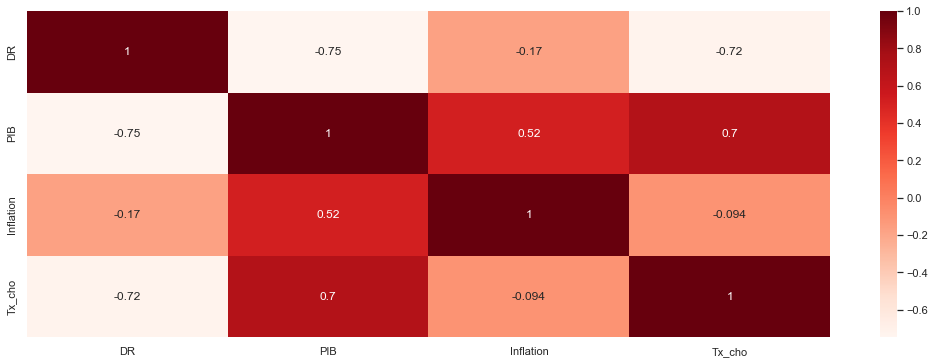

In [134]:
corre(X8[col_macro],Y8)

### Multicollinéarité test
On va analyser les différentes colonnes obtenues et enlever les variables qui sont trop colinéaires entre elles

In [135]:
def keep_col(df, Y, tresholdDR,interTreshold):
  df_temp = df.copy()
  df_temp.insert(loc=0, column='DR', value=Y8.values)
  corr_matrix = df_temp.corr()
  *index, = map(lambda x: abs(x)>tresholdDR,corr_matrix.loc['DR'])
  print('Columns with corr with DR >' +str(tresholdDR)+':',df_temp.columns[index].values[1:],str(index.count(True)-1)+' variables',sep='\n')
  
  print('\n','After studying inter correlation')
  keep_col = set()
  cols = df_temp.columns[index].values[1:]
  for col1 in cols:
    for col2 in cols:
      if col1 != col2 and abs(corr_matrix.loc[col1,col2])>interTreshold:
        col_to_keep =corr_matrix.loc['DR',[col1,col2]].idxmax()
        keep_col.add(col_to_keep)
  print('Columns with inter corr<' +str(interTreshold)+':',keep_col,str(len(keep_col))+' variables',sep='\n')
  return list(keep_col)

In [136]:
col_8_corr = keep_col(X8, Y8,0.60,0.90)

Columns with corr with DR >0.6:
['mean_1' 'median_1' 'p25_1' 'p75_1' 'p90_1' 'p95_1' 'mean_4' 'p10_4'
 'p25_4' 'p75_4' 'p90_4' 'p95_4' 'mean_5' 'p25_5' 'p95_5' 'p95_6' 'mean_7'
 'median_7' 'p5_7' 'p25_7' 'p75_7' 'mean_8' 'median_8' 'p75_8' 'p95_8'
 'CD_TY_CLI_RCI_1' 'CD_ETA_CIV_1' 'CD_MOD_HABI_1' 'CD_QUAL_VEH_1' 'PIB'
 'Tx_cho']
31 variables

 After studying inter correlation
Columns with inter corr<0.9:
{'p95_5', 'p25_1', 'p25_7', 'mean_5', 'p95_4', 'p75_1', 'mean_1', 'CD_QUAL_VEH_1', 'mean_7', 'CD_ETA_CIV_1', 'mean_4', 'mean_8', 'p5_7', 'median_1', 'p25_5', 'p90_1', 'p95_1', 'PIB', 'p75_4', 'p95_8', 'p75_7', 'p90_4', 'median_7'}
23 variables


### Conclusion

In [137]:
col_8_corr = list(set(col_8_corr))
print(f'Il y a {len(col_8_corr)} variables:', col_8_corr,sep='\n')

Il y a 23 variables:
['p95_5', 'p25_1', 'p25_7', 'mean_5', 'p95_4', 'p75_1', 'mean_1', 'CD_QUAL_VEH_1', 'mean_7', 'CD_ETA_CIV_1', 'mean_4', 'mean_8', 'p5_7', 'median_1', 'p25_5', 'p90_1', 'p95_1', 'PIB', 'p75_4', 'p95_8', 'p75_7', 'p90_4', 'median_7']


## Low variance method

In [138]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold =0.25).fit(X8)
col_8_vt = X8.loc[:,vt.get_support()].columns
print(f'Il y a {len(col_8_vt)} variables:', col_8_vt,sep='\n')

Il y a 31 variables:
Index(['mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2', 'p90_2',
       'p95_2', 'mean_3', 'median_3', 'p5_3', 'p10_3', 'p25_3', 'p75_3',
       'p90_3', 'p95_3', 'mean_4', 'median_4', 'p25_4', 'p75_4', 'p90_4',
       'p95_4', 'mean_5', 'p5_5', 'p10_5', 'p25_5', 'p75_5', 'p90_5', 'p95_5',
       'PIB', 'Inflation'],
      dtype='object')


## Kbest method

In [139]:
from sklearn.feature_selection import SelectKBest, f_regression
kb = SelectKBest(f_regression, k=20).fit(X8, Y8)
col_8_kb = X8.loc[:,kb.get_support()].columns
print(f'Il y a {len(col_8_kb)} variables:', col_8_kb,sep='\n')

Il y a 20 variables:
Index(['mean_1', 'median_1', 'p25_1', 'p75_1', 'p90_1', 'p95_1', 'mean_4',
       'p75_4', 'p90_4', 'mean_5', 'p25_5', 'mean_7', 'p5_7', 'mean_8',
       'median_8', 'CD_ETA_CIV_1', 'CD_MOD_HABI_1', 'CD_QUAL_VEH_1', 'PIB',
       'Tx_cho'],
      dtype='object')


## Recursive feature elimination with cross-validation to select features.



In [140]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
rfecv = RFECV(linreg, step=1, min_features_to_select=15, cv=8).fit(X8, Y8)
col_8_rfecv = X8.loc[:,rfecv.get_support()].columns
print(f'Il y a {len(col_8_rfecv)} variables:', col_8_rfecv,sep='\n')


Il y a 60 variables:
Index(['mean_1', 'median_1', 'p5_1', 'p10_1', 'p25_1', 'p75_1', 'p90_1',
       'p95_1', 'mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2',
       'p90_2', 'p95_2', 'mean_3', 'median_3', 'p5_3', 'p10_3', 'p25_3',
       'p75_3', 'p90_3', 'p95_3', 'mean_4', 'median_4', 'p5_4', 'p10_4',
       'p25_4', 'p75_4', 'p90_4', 'p95_4', 'mean_5', 'p5_5', 'p75_5', 'p5_6',
       'p25_6', 'mean_7', 'median_7', 'p5_7', 'p10_7', 'p25_7', 'p75_7',
       'p90_7', 'p95_7', 'mean_8', 'median_8', 'p5_8', 'p25_8', 'p75_8',
       'p90_8', 'p95_8', 'CD_TY_CLI_RCI_1', 'CD_ETA_CIV_1', 'CD_MOD_HABI_1',
       'CD_PROF_1', 'CD_PROF_2', 'CD_QUAL_VEH_1', 'Inflation', 'Tx_cho'],
      dtype='object')


## Feature selection using SelectFromModel

In [141]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(fit_intercept=False)
sfm = SelectFromModel(linreg).fit(X8, Y8)
col_8_sfm  = Xt.loc[:,sfm .get_support()].columns
print(f'Il y a {len(col_8_sfm )} variables:', col_8_sfm ,sep='\n')


Il y a 20 variables:
Index(['mean_2', 'median_2', 'p5_2', 'p10_2', 'p25_2', 'p75_2', 'p95_2',
       'mean_3', 'p5_3', 'p10_3', 'p25_3', 'p75_3', 'p95_3', 'median_4',
       'p10_4', 'p25_4', 'p75_4', 'p90_4', 'p95_4', 'Tx_cho'],
      dtype='object')


## Tree-based feature selection

In [142]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
etc = ExtraTreesRegressor(n_estimators=50).fit(X8, Y8)
sfm2 = SelectFromModel(etc, prefit=True)
col_8_sfm2  = X8.loc[:,sfm2 .get_support()].columns
print(f'Il y a {len(col_8_sfm2 )} variables:', col_8_sfm2 ,sep='\n')


Il y a 21 variables:
Index(['mean_1', 'p75_1', 'p90_1', 'p95_2', 'p25_3', 'mean_4', 'p75_4',
       'p90_4', 'mean_5', 'p25_5', 'p95_5', 'mean_7', 'p5_7', 'p25_7', 'p90_7',
       'mean_8', 'median_8', 'CD_TY_CLI_RCI_1', 'CD_ETA_CIV_1',
       'CD_QUAL_VEH_1', 'PIB'],
      dtype='object')


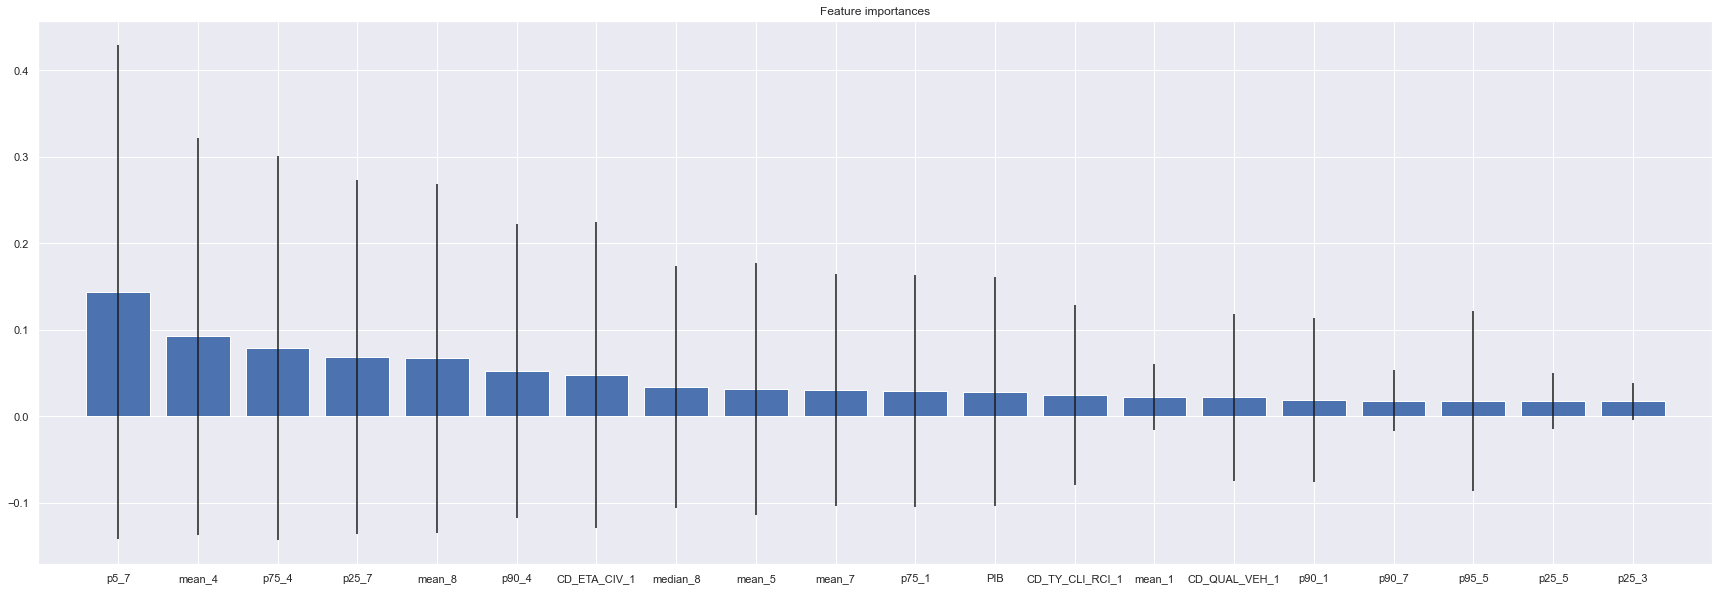

In [143]:
#plot the importances #
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:20]
indices_names = list(map(lambda x : X8.columns[x],indices))
plt.figure(figsize=(30,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), indices_names)
plt.xlim([-1, len(indices)])
plt.show()

## Sequential Feature Selection 

In [144]:
# forward
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
linreg = LinearRegression(fit_intercept=False)
sfs_forward = SequentialFeatureSelector(linreg, n_features_to_select=20, direction='forward').fit(X8, Y8)
col_8_sfs_forward  = X8.loc[:,sfs_forward .get_support()].columns
print(f'Il y a {len(col_8_sfs_forward )} variables:', col_8_sfs_forward ,sep='\n')

Il y a 20 variables:
Index(['p5_2', 'p10_2', 'p25_2', 'median_3', 'p90_3', 'mean_4', 'p5_4',
       'p25_4', 'p75_4', 'p95_4', 'mean_5', 'p5_5', 'p10_6', 'p25_6', 'p75_6',
       'p90_6', 'p95_6', 'p10_8', 'p25_8', 'CD_MOD_HABI_1'],
      dtype='object')


In [145]:
# backward
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
linreg = LinearRegression(fit_intercept=False)
sfs_backward = SequentialFeatureSelector(linreg, n_features_to_select=20, direction='backward').fit(X8, Y8)
col_8_sfs_backward  = X8.loc[:,sfs_backward .get_support()].columns
print(f'Il y a {len(col_8_sfs_backward )} variables:', col_8_sfs_backward ,sep='\n')

Il y a 20 variables:
Index(['mean_2', 'median_2', 'p10_2', 'p25_2', 'p75_2', 'p95_2', 'p5_3',
       'p10_3', 'p75_3', 'p90_3', 'mean_4', 'median_4', 'p25_4', 'p75_4',
       'p90_4', 'p95_4', 'mean_5', 'p5_5', 'p25_5', 'p95_5'],
      dtype='object')


## Show what feature was selected

In [146]:
cols_feature_selection_8 = [col_8_corr,col_8_vt,col_8_kb,col_8_rfecv,col_8_sfm,col_8_sfm2,col_8_sfs_forward,col_8_sfs_backward]
method = ['Methode correlation','Low variance methode','Methode Kbest','Methode RFECV','Methode SelectFromModel','Method Tree','Methode sequential forward','Methode sequential backward']

In [147]:
for cols, met in zip(cols_feature_selection_8,method):
  print('-'*40)
  print(f'{met}: {len(cols)} variables')
  print(*cols)
print('-'*40,end='\n')

----------------------------------------
Methode correlation: 23 variables
p95_5 p25_1 p25_7 mean_5 p95_4 p75_1 mean_1 CD_QUAL_VEH_1 mean_7 CD_ETA_CIV_1 mean_4 mean_8 p5_7 median_1 p25_5 p90_1 p95_1 PIB p75_4 p95_8 p75_7 p90_4 median_7
----------------------------------------
Low variance methode: 31 variables
mean_2 median_2 p5_2 p10_2 p25_2 p75_2 p90_2 p95_2 mean_3 median_3 p5_3 p10_3 p25_3 p75_3 p90_3 p95_3 mean_4 median_4 p25_4 p75_4 p90_4 p95_4 mean_5 p5_5 p10_5 p25_5 p75_5 p90_5 p95_5 PIB Inflation
----------------------------------------
Methode Kbest: 20 variables
mean_1 median_1 p25_1 p75_1 p90_1 p95_1 mean_4 p75_4 p90_4 mean_5 p25_5 mean_7 p5_7 mean_8 median_8 CD_ETA_CIV_1 CD_MOD_HABI_1 CD_QUAL_VEH_1 PIB Tx_cho
----------------------------------------
Methode RFECV: 60 variables
mean_1 median_1 p5_1 p10_1 p25_1 p75_1 p90_1 p95_1 mean_2 median_2 p5_2 p10_2 p25_2 p75_2 p90_2 p95_2 mean_3 median_3 p5_3 p10_3 p25_3 p75_3 p90_3 p95_3 mean_4 median_4 p5_4 p10_4 p25_4 p75_4 p90_4 p9

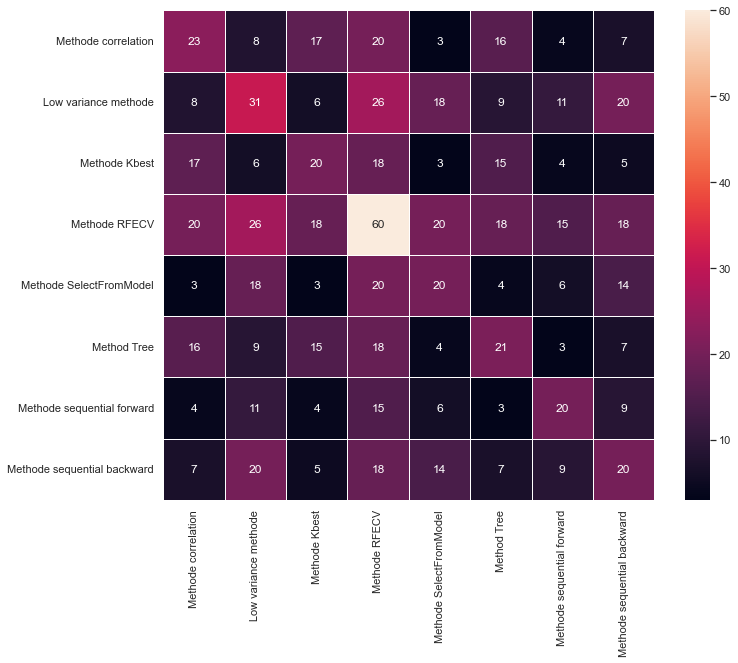

In [148]:
import itertools
df_common = pd.DataFrame(columns=method, index=method)
for i, j in itertools.product(range(len(method)),range(len(method))):
  col1, col2 = cols_feature_selection_8[i], cols_feature_selection_8[j]
  method1, method2 = method[i], method[j]
  n_common = len(set(col1).intersection(col2))
  df_common.loc[method1,method2] = n_common

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_common.astype('float64'), annot=True,linewidth=.5,ax=ax)
plt.show()